
This notebook performs Binary Classification on the "Income Classification Dataset" using KNN.

**1. Importing Libraries**

In [ ]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

**2. Mounting Drive**

**3. Load the Dataset**

In [12]:
df = pd.read_csv("superstore_final_dataset.csv", encoding="latin1")
df.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales
0,1,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/6/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold N Roll Cart System,22.3680


**3. Normalizing the Column Strings**

In [13]:
df.columns = df.columns.str.strip()
df.head(4)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales
0,1,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/6/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775


**4. Identify Categorical/Numerical Columns**

In [14]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
numerical = df.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical:", categorical)
print("Numerical:", numerical)

Categorical: ['Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode', 'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State', 'Region', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name']
Numerical: ['Row_ID', 'Postal_Code', 'Sales']


**5. Replace “?” with NaN and Impute with Mode (No chained inplace warnings)**

In [15]:
# Replace '?' if exists
for col in categorical:
    df[col] = df[col].replace(['?', ' ?'], np.nan)

# Fill missing categorical values with mode
for col in categorical:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Fill numeric missing values with median
for col in numerical:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

print("Total missing:", df.isnull().sum().sum())

Total missing: 0


**6. Split Train Test (x,y)**

In [16]:
median_sales = df['Sales'].median()

df['Sales_Class'] = df['Sales'].apply(
    lambda x: 1 if x >= median_sales else 0
)
X = df.drop(columns=['Sales', 'Sales_Class'])
y = df['Sales_Class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(X_train.shape, X_test.shape)

(7840, 17) (1960, 17)


**6. Preprocessing (OneHot for categorical + RobustScaler for numeric)**

In [17]:
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

print("X_train_prep shape:", X_train_prep.shape)
print("X_test_prep shape :", X_test_prep.shape)

X_train_prep shape: (7840, 12696)
X_test_prep shape : (1960, 12696)


**7. PCA (4 components) + KNN Training**

Best K value: 18
KNN training took 0.017 seconds
KNN testing took 0.044 seconds


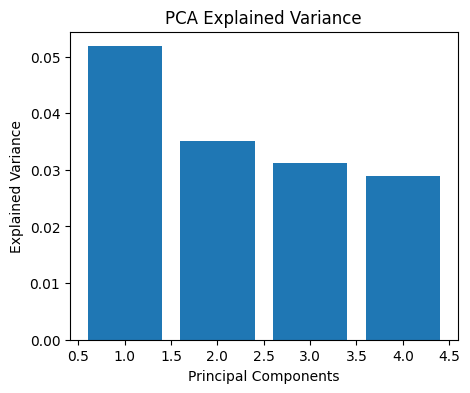

In [19]:
# Handle any remaining NaN values before PCA
X_train_prep = np.nan_to_num(X_train_prep, nan=0.0)
X_test_prep  = np.nan_to_num(X_test_prep, nan=0.0)

# PCA
pca = PCA(n_components=4, random_state=42)
X_train_reduced = pca.fit_transform(X_train_prep)
X_test_reduced  = pca.transform(X_test_prep)

# Explained variance of PCA components
explained_variance = pca.explained_variance_ratio_

# -----------------------------
# KNN Hyperparameter Tuning
# -----------------------------
from sklearn.metrics import accuracy_score

k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_reduced, y_train)
    y_pred_k = knn_temp.predict(X_test_reduced)
    accuracies.append(accuracy_score(y_test, y_pred_k))

best_k = k_values[np.argmax(accuracies)]
print("Best K value:", best_k)

# -----------------------------
# Final KNN Model
# -----------------------------
knn = KNeighborsClassifier(n_neighbors=best_k)

start_time = time.time()
knn.fit(X_train_reduced, y_train)
print(f'KNN training took {time.time()-start_time:.3f} seconds')

start_time = time.time()
y_pred = knn.predict(X_test_reduced)
print(f'KNN testing took {time.time()-start_time:.3f} seconds')

# -----------------------------
# PCA Variance Plot
# -----------------------------
plt.figure(figsize=(5,4))
plt.bar(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


**8. Evaluation (Accuracy + Report + Confusion Matrix)**

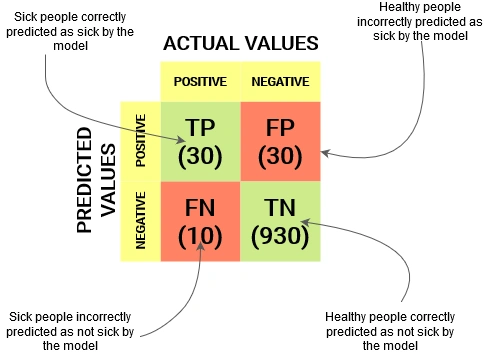

KNN Accuracy: 0.7010204081632653

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.80      0.73       980
           1       0.75      0.60      0.67       980

    accuracy                           0.70      1960
   macro avg       0.71      0.70      0.70      1960
weighted avg       0.71      0.70      0.70      1960

Confusion Matrix:
 [[785 195]
 [391 589]]


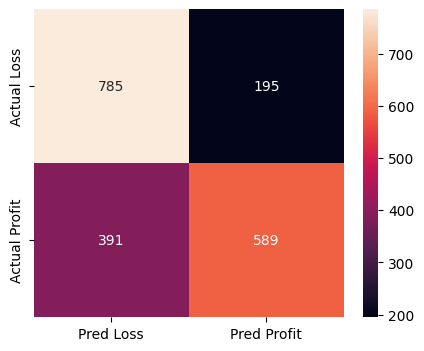

In [ ]:
print("KNN Accuracy:", knn.score(X_test_reduced, y_test))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Cross Validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=5,
    scoring='accuracy'
)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# K vs Accuracy Plot
plt.figure(figsize=(5,4))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("K Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN Hyperparameter Tuning Curve")
plt.grid()
plt.show()

cm_df = pd.DataFrame(
    cm,
    index=['Actual Loss', 'Actual Profit'],
    columns=['Pred Loss', 'Pred Profit']
)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.show()